<center><font size="6"><b>Frequency equalizer</b></font></center>
<br />
<center><font size="2"><b><u>Created by: Mikołaj Pichita</u></b></font></center>

Setup:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.io import wavfile
import IPython.display as ipd
sample_rate, data=wavfile.read('JPEGMAFIA_HAZARD_DUTY_PAY.wav') #https://jpegmafia.bandcamp.com/

C:\Users\Mikołaj\AppData\Local\Temp\ipykernel_19724\3102709833.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data=wavfile.read('JPEGMAFIA_HAZARD_DUTY_PAY.wav') #https://jpegmafia.bandcamp.com/


The song has been sampled with $fs=48kHz$, that means that when when cosine transform with 32 subbands will be applied, a single subband will have a bandwidth of 750Hz.

 - 0 - (0,750) Bass+LowMid
 - 1 - (750,1500) MidMid+HighMid
 - 2 - (1500,2250) HighMid
 - 3:6 - (2250,5250) LowTreble
 - 7:12 - (5250,9750) MidTreble
 - 13:32 - (9750,24000) HighTreble

In [3]:
M=N=32 				# number of channels
band_boost=[0] 		# subband to amplify
band_att=[2] 		# subband to attenuate
boost=3 			# gain factor
attenuate=0.5 		# attenuation factor

Subband filtration fuction declarations:

In [4]:
# prototype filters with quasi-perfect reconstruction

a=np.zeros(8)
a[0]=1; a[1]=-0.99998229; a[2]=0.99692250
a[4]=1/2**0.5; a[6]=(1-a[2]**2)**0.5; a[7]=-(1-a[1]**2)**0.5
C=-(a[0]/2+a[1]+a[2]+a[4]+a[6]+a[7])
a[3]=C/2 - (0.5-C**2/4)**0.5; a[5]=-(1-a[3]**2)**0.5

Lp=512
p=np.zeros(Lp)
for n in range(Lp):
    suma=0
    for k in range(1,8):
        suma+=a[k]*np.cos(2*np.pi*k*n/Lp)
    p[n]=1/Lp*(a[0]+2*suma)

In [5]:
def analysis_filters(N,p):
    Lp=len(p)
    h=np.zeros([N,Lp])
    
    for k in range(N):
        for n in range(Lp):
            h[k][n]=2*p[n]*np.cos(np.pi/N * (k+0.5)*(n-(Lp-1)/2)+(-1)**k * np.pi/4)
    
    return h

In [6]:
def synthesis_filters(N,p):
    Lp=len(p)
    g=np.zeros([N,Lp])

    for k in range(N):
        for n in range(Lp):
            g[k][n]=2*p[n]*np.cos(np.pi/N * (k+0.5)*(n-(Lp-1)/2)-(-1)**k * np.pi/4)
    
    return g

In [7]:
def downsample(x, K, t=None):
    y_K=x[0:len(x):K]
    if t is None:
        return y_K
    t_K=t[0:len(t):K]
    return y_K, t_K

In [8]:
def upsample(x, L, t=None):
    l=len(x)*L
    y_L=np.zeros(l)
    for i in range(len(x)):
        y_L[i*L]=x[i]      
    if t is None:
        return y_L
    dt=(t[1]-t[0])/L
    t_L=np.linspace(0,dt*(l-1),l)
    return y_L, t_L

In [9]:
def analysis(x,N,p):
    h_fake=np.ones(len(p))
    x_fake=np.ones(len(x))
    y_fake=np.convolve(h_fake,x_fake)
    y_fake2=downsample(y_fake,N)

    h=analysis_filters(N,p)
    y=np.zeros([N,len(y_fake2)])

    for k in range(N):
        temp=np.convolve(h[k],x)
        temp=downsample(temp,N)
        y[k]=temp
    
    return y

In [10]:
def equalize(x,band_boost,band_att,boost,attenuate):

    x*=32  # prototype filter compensations
    
    x[band_boost]*=boost
    x[band_att]*=attenuate
    

    return x

In [11]:
def synthesis(y,N,p):
    g_fake=np.ones(len(p))
    y_fake=np.ones(len(y[0]))
    z_fake=upsample(y_fake,N)
    z_fake2=np.convolve(g_fake,z_fake)
    
    g=synthesis_filters(N,p)
    z=np.zeros([N,len(z_fake2)])
    
    for k in range(N):
        temp=upsample(y[k],N)
        temp=np.convolve(temp,g[k])
        z[k]=temp
        
    suma=np.zeros(len(z[0]))
    
    for x in range(len(z[0])):
        for y in range(N):
            suma[x]+=z[y][x]

    return suma

For the best result, low frequencies will be amplified/attenuated.

In [12]:
data_left=data[:,0]
data_right=data[:,1]

# analysis -> gain -> synthesis

# left channel
left_post_a=analysis(data_left,N,p)
left_post_eq=equalize(left_post_a,band_boost,band_att,boost,attenuate)
left_done=synthesis(left_post_eq,N,p)

D_L=np.fft.fft(data_left,sample_rate)
D_L=D_L[0:sample_rate//2]
D_FL=np.fft.fft(left_done,sample_rate)
D_FL=D_FL[0:sample_rate//2]

# right channel
right_post_a=analysis(data_right,N,p)
right_post_eq=equalize(right_post_a,band_boost,band_att,boost,attenuate)
right_done=synthesis(right_post_eq,N,p)

D_R=np.fft.fft(data_right,sample_rate)
D_R=D_R[0:sample_rate//2]
D_FR=np.fft.fft(right_done,sample_rate)
D_FR=D_FR[0:sample_rate//2]



In [ ]:
# DO NOT EXECUTE THIS CELL
# print(np.max(data_right)/np.max(right_done))

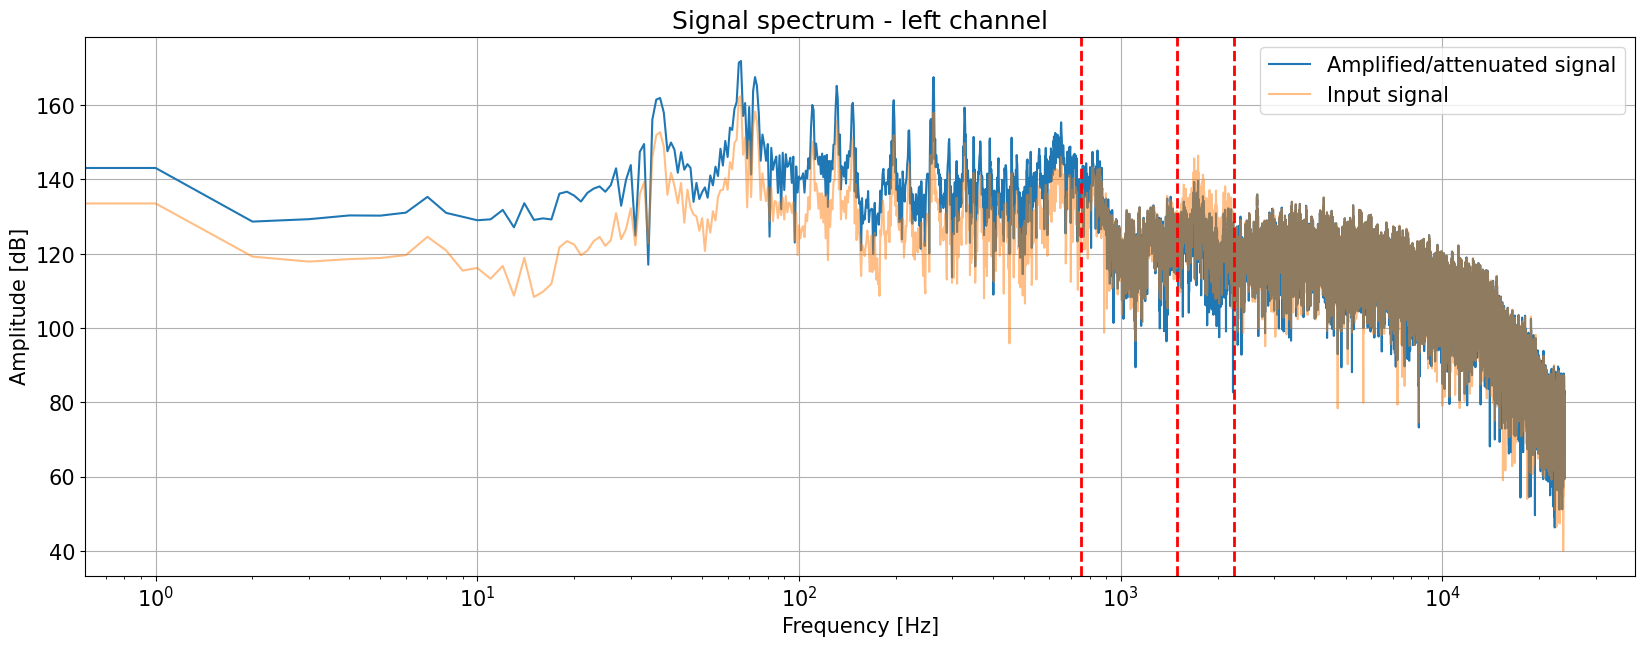

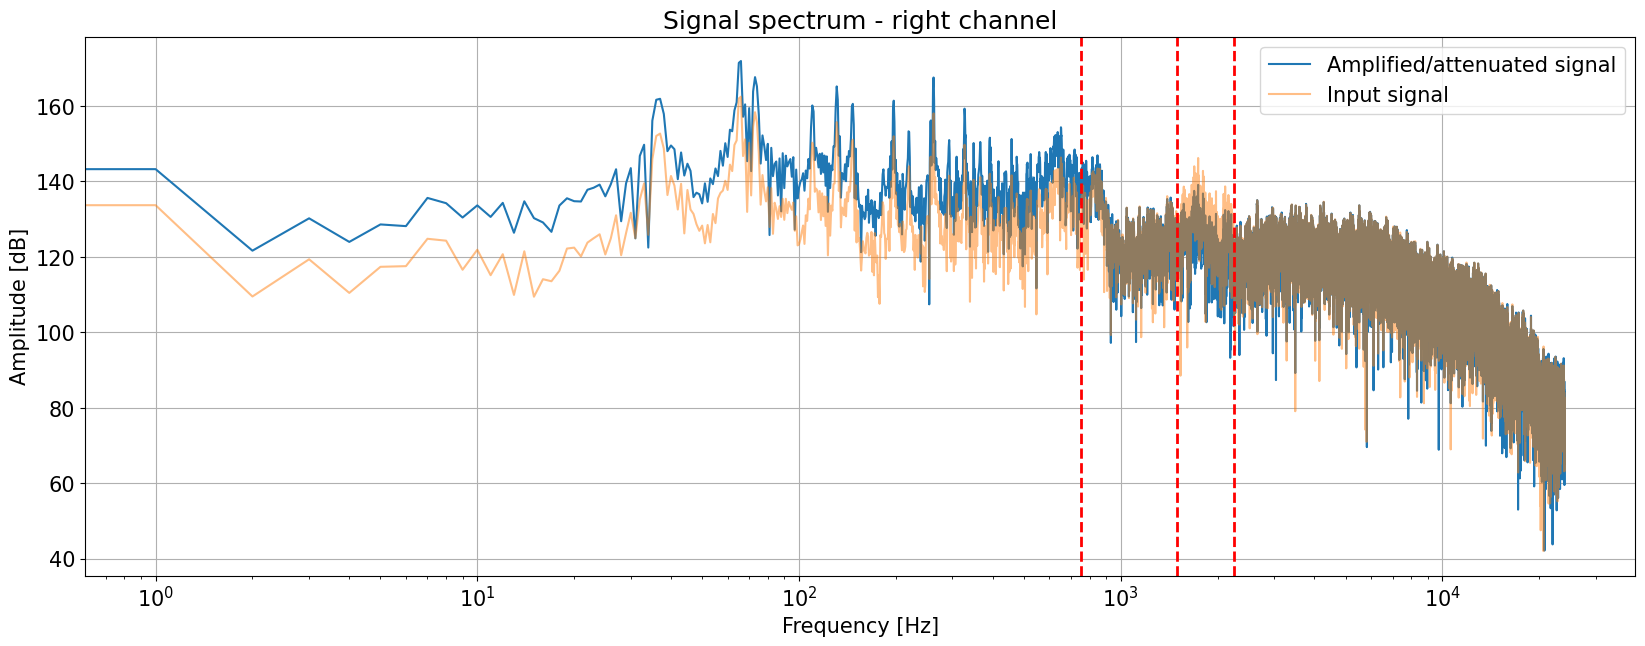

In [14]:
plt.rc('font', size=15)

fig = plt.figure(figsize=(20, 7))

plt.plot(20*np.log10(np.abs(D_FL))+1e-15, label='Amplified/attenuated signal')
plt.plot(20*np.log10(np.abs(D_L))+1e-15, label='Input signal',alpha=0.5)
plt.axvline(750,color='red',ls='--',linewidth=2)
plt.axvline(1500,color='red',ls='--',linewidth=2)
plt.axvline(2250,color='red',ls='--',linewidth=2)
plt.title('Signal spectrum - left channel')
plt.semilogx()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.grid()
plt.legend()

fig = plt.figure(figsize=(20, 7))

plt.plot(20*np.log10(np.abs(D_FR))+1e-15, label='Amplified/attenuated signal')
plt.plot(20*np.log10(np.abs(D_R))+1e-15, label='Input signal',alpha=0.5)
plt.axvline(750,color='red',ls='--',linewidth=2)
plt.axvline(1500,color='red',ls='--',linewidth=2)
plt.axvline(2250,color='red',ls='--',linewidth=2)
plt.title('Signal spectrum - right channel')
plt.semilogx()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.grid()
plt.legend()


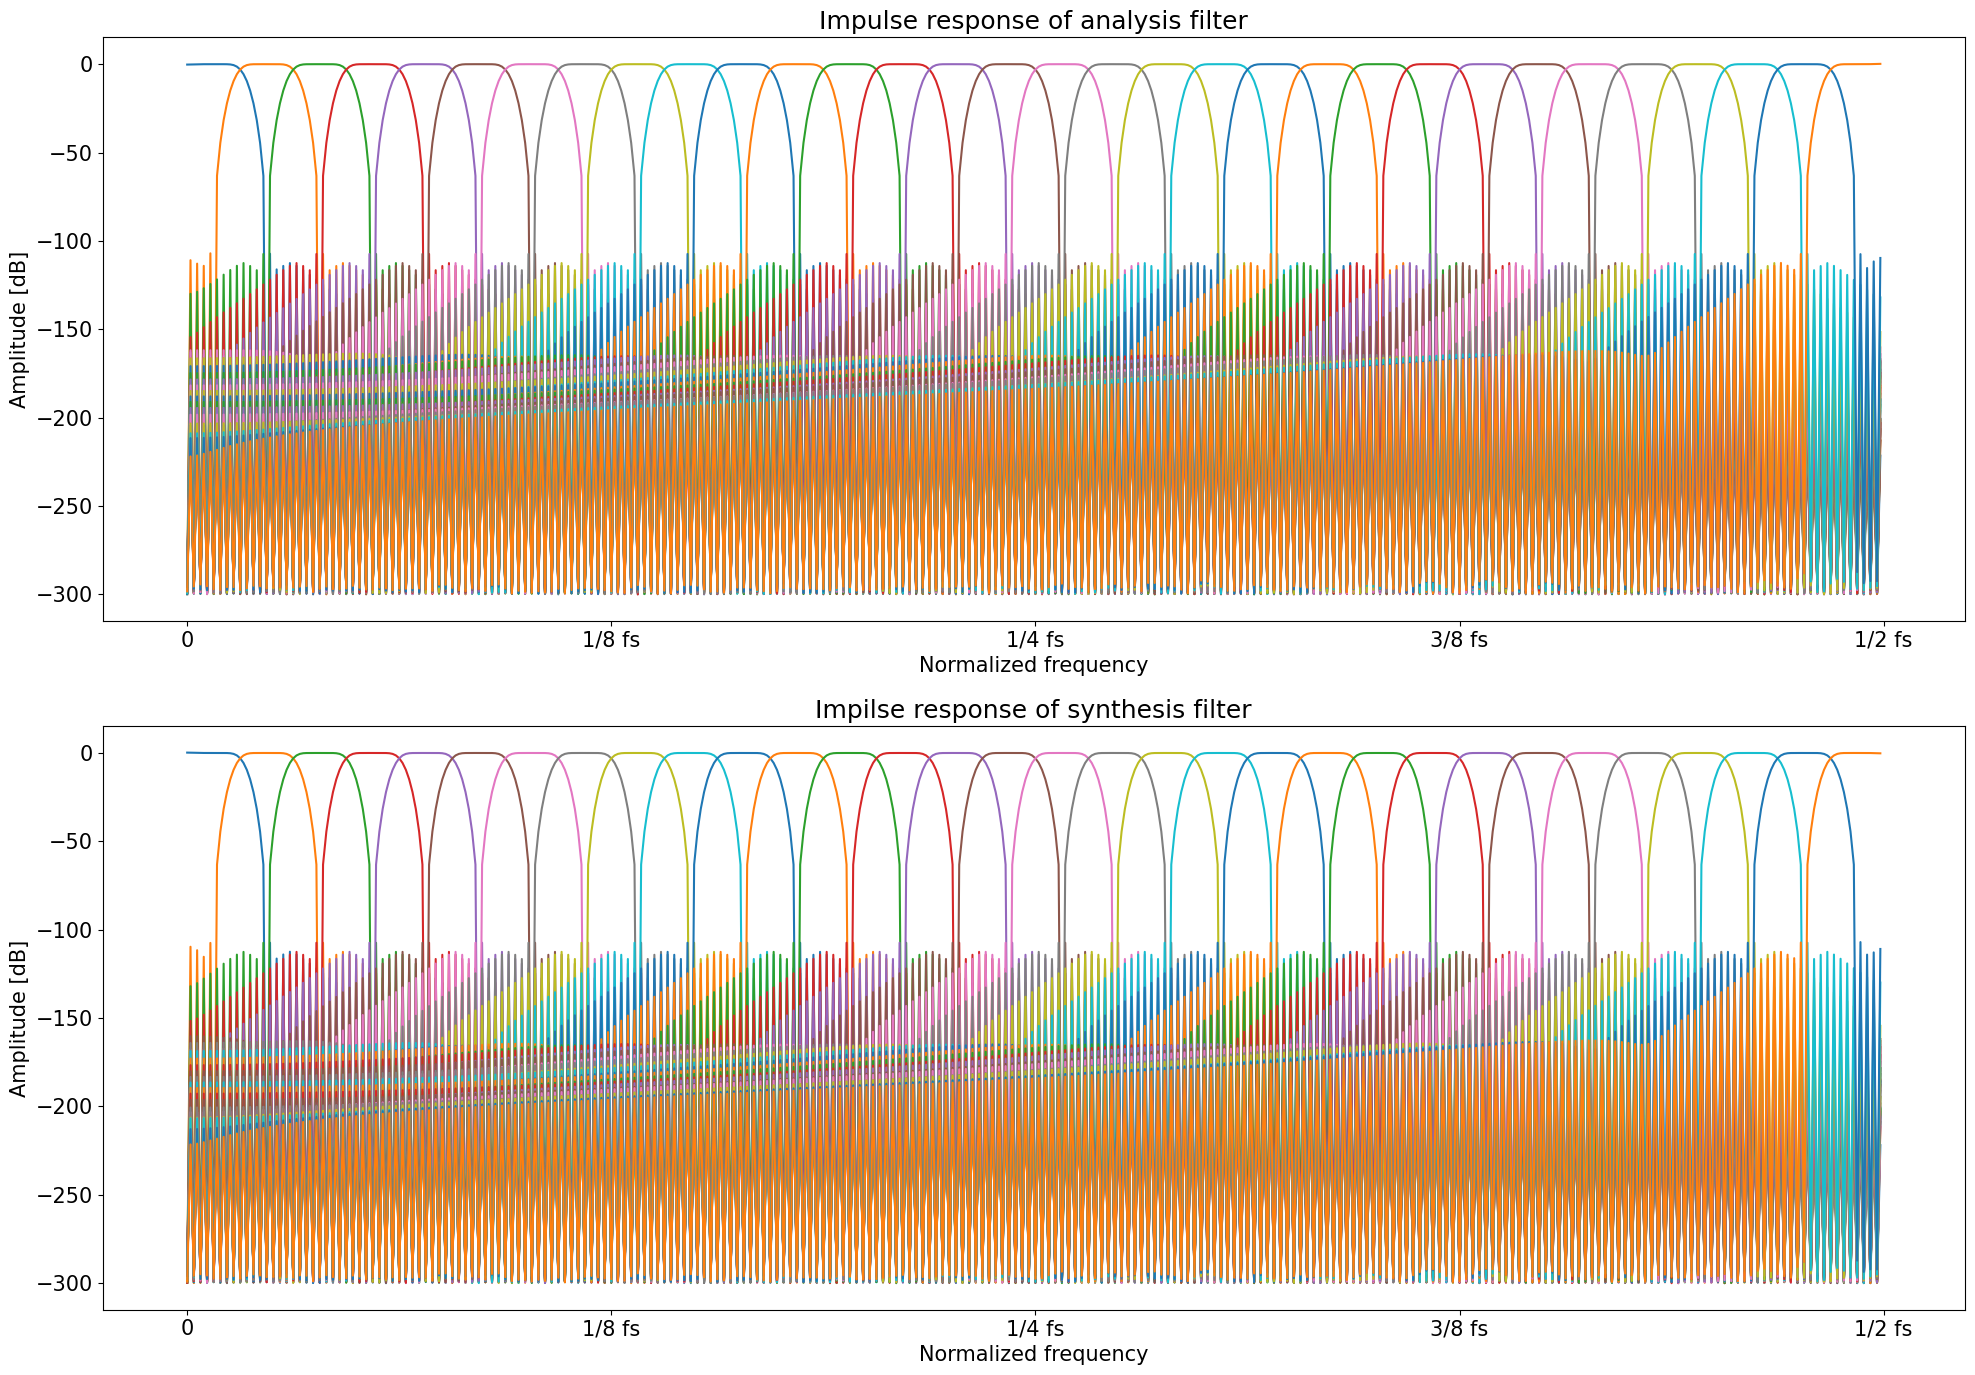

In [16]:
h=analysis_filters(N,p)       
g=synthesis_filters(N,p)

fig, ax = plt.subplots(2, 1, figsize=(20, 14))

for k in range(M):
    _, H = scipy.signal.freqz(h[k])
    ax[0].plot(20*np.log10(abs(H)+1e-15))
ax[0].set_title('Impulse response of analysis filter')
ax[0].set_xlabel('Normalized frequency')
ax[0].set_ylabel('Amplitude [dB]')
ax[0].set_xticks([0, len(H)/4, len(H)/2, 3*len(H)/4, len(H)])
ax[0].set_xticklabels(['0', r'1/8 fs', '1/4 fs', '3/8 fs', '1/2 fs'])
    
for k in range(M):
    _, G = scipy.signal.freqz(g[k])
    ax[1].plot(20*np.log10(abs(G)+1e-15))
ax[1].set_title('Impilse response of synthesis filter')
ax[1].set_xlabel('Normalized frequency')
ax[1].set_ylabel('Amplitude [dB]')
ax[1].set_xticks([0, len(G)/4, len(G)/2, 3*len(G)/4, len(G)])
ax[1].set_xticklabels(['0', r'1/8 fs', '1/4 fs', '3/8 fs', '1/2 fs'])


plt.tight_layout()

In [17]:
# calculating filter impulse response, no gain or attenuation
x=scipy.signal.unit_impulse(data_left.size)

x_post_a=analysis(x,N,p)
x_post_eq=equalize(x_post_a,0,0,1,1)
x_done=synthesis(x_post_eq,N,p)

X_eq=np.fft.fft(x_done,sample_rate)
X_eq=X_eq[0:sample_rate//2]

# calculating filter impulse response with gain and/or attenuation
x_post_a=analysis(x,N,p)
x_post_eq=equalize(x_post_a,band_boost,band_att,boost,attenuate)
x_done=synthesis(x_post_eq,N,p)

X_eqb=np.fft.fft(x_done,sample_rate)
X_eqb=X_eqb[0:sample_rate//2]

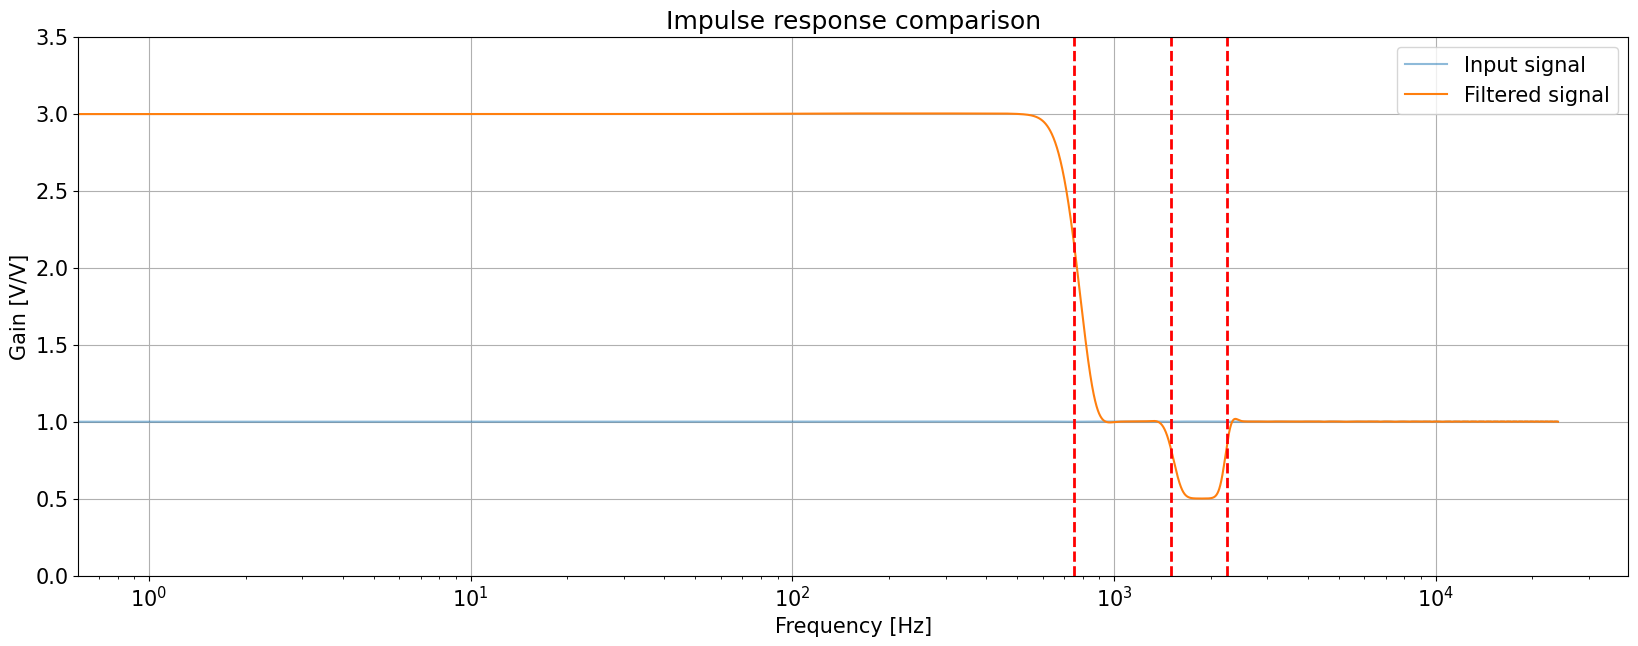

In [19]:
fig = plt.figure(figsize=(20, 7))

plt.plot(abs(X_eq),label='Input signal',alpha=0.5)
plt.plot(abs(X_eqb),label='Filtered signal')
plt.axvline(750,color='red',ls='--',linewidth=2)
plt.axvline(1500,color='red',ls='--',linewidth=2)
plt.axvline(2250,color='red',ls='--',linewidth=2)
plt.title('Impulse response comparison')
plt.semilogx()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [V/V]')
plt.ylim([0,3.5])
plt.grid()
plt.legend()


Filtration with audio example:

In [20]:
print('Unfiltered signal')
display(ipd.Audio(data=data.T, rate=sample_rate))

left_done=left_done.reshape(1,left_done.size)
right_done=right_done.reshape(1,right_done.size)
lr_done=np.concatenate([left_done,right_done],axis=0)

print('Filtered signal')
display(ipd.Audio(data=lr_done, rate=sample_rate))

Unfiltered signal


Filtered signal
